In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
from scipy.stats import norm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils
from matplotlib import colors
from settings import colors as nc_colors
from settings import ax_label_size, tick_label_size, letter_size, lw

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
base_path = "/storage/noise_correlations/exp10"

In [4]:
pvc11_1_path = os.path.join(base_path, 'exp10_1_pvc11_20_1000_1000.h5')
ret2_path = os.path.join(base_path, 'exp10_ret2_20_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp10_ecog_20_3000_1000.h5')

In [5]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
#pvc11_2 = h5py.File(pvc11_2_path, 'r')
#pvc11_3 = h5py.File(pvc11_3_path, 'r')
#ret2 = h5py.File(ret2_path, 'r')
#ecog = h5py.File(ecog_path, 'r')
#results = [pvc11_1, pvc11_2, pvc11_3, ret2, ecog]
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
idxs = np.argsort(pvc11_1['p_r_lfi'][0])[:20]

In [6]:
def plot_marginals(mu, cov, lim, pcts, ax, compare=True, denom=.18):
    marginal_pdf0 = norm(loc=mu[0], scale=np.sqrt(cov[0, 0]))
    marginal_pdf1 = norm(loc=mu[1], scale=np.sqrt(cov[1, 1]))
    v0 = marginal_pdf0.cdf(pcts[0])
    v1 = marginal_pdf1.cdf(pcts[1])
    xs = np.linspace(lim[0], lim[1], 4800)
    idxs = xs < pcts[0]
    ys0 = marginal_pdf0.pdf(xs)
    ys1 = marginal_pdf1.pdf(xs)
    ax.plot(xs, -ys0 * lim[0] / denom + lim[0], c='k', lw=1)
    c = 'gray'
    if compare:
        if v0 > v1:
            ax.text(-4.5, -7, r'ND', size=tick_label_size, ha='center', va='center')
            c = 'dimgray'
        else:
            ax.text(-6, -2.5, r'ND', size=tick_label_size, ha='center', va='center')
            c = 'lightgray'
    ax.fill_between(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys0[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)
    idxs = xs < pcts[1]
    ys = marginal_pdf1.pdf(xs)
    ax.plot(-ys1 * lim[0] / denom + lim[0], xs,c='k', lw=lw)
    if compare:
        if v0 > v1:
            c = 'lightgray'
        else:
            c = 'dimgray'
    ax.fill_betweenx(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys1[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)

def plot_fano(mu, cov, ax, label=True):
    ax.errorbar(23, mu[1],
                yerr=[np.sqrt(cov[1, 1])], c='k',
                capsize=2, capthick=1, elinewidth=1,
                marker='o', ms=1)
    ax.text(24, mu[1], r'$\sigma_2$', size=tick_label_size)
    ax.text(mu[0] - 5 - np.sqrt(cov[0, 0]), 24, r'$\sigma_1$', size=tick_label_size)
    ax.errorbar(mu[0], 23,
                xerr=[np.sqrt(cov[0, 0])], c='k',
                capsize=2, capthick=1, elinewidth=1,
                marker='o', ms=1)

def plot_corr(mu, cov, ax):
    w, v = np.linalg.eigh(utils.cov2corr(cov))
    ax.text(24, mu[1], r'$\sigma_2$', size=tick_label_size)
    ax.text(mu[0] - 5 - np.sqrt(cov[0, 0]), 24, r'$\sigma_1$', size=tick_label_size)
    ax.errorbar(23, mu[1],
                yerr=[np.sqrt(cov[1, 1])], c='k',
                capsize=2, capthick=1, elinewidth=1,
                marker='o', ms=2)
    ax.errorbar(mu[0], 23,
                xerr=[np.sqrt(cov[0, 0])], c='k',
                capsize=2, capthick=1, elinewidth=1,
                marker='o', ms=2)

uniform p: 0.001
fa p: 0.0


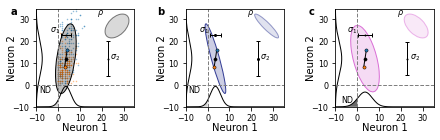

In [22]:
figsize = (6, 1.75)
fig = plt.figure(figsize=figsize)
le = .07
re = .01
te = .02
be = .2
vg = .08
h = 1. - te - be
w = h * figsize[1] / figsize[0]
hg = (1. - le - re - 3*w) / 2.

axes = np.empty(3, dtype=object)
for ii in range(3):
    axes[ii] = fig.add_axes([le + ii*(w + hg), be, w, h])

idx = idxs[8]
units = pvc11_1['units'][0, idx][:2]
Xu = pvc11_1['X'][:][:, units]
pcts = np.percentile(Xu, 1, axis=0)
opt = pvc11_1['opt_covs/3'][idx]
opt_fa = pvc11_1['opt_fa_covs/3'][idx]
opt_u = pvc11_1['opt_u_covs/3'][idx]
print('uniform p:', pvc11_1['p_u_lfi'][0, idx])
print('fa p:', pvc11_1['p_fa_lfi'][0, idx])
X1, X2 = utils.get_dimstim_responses_from_h5(pvc11_1, 0, idx)
cov1 = np.cov(X1.T)
cov2 = np.cov(X2.T)
obs = 0.5 * (cov1 + cov2)
mu1 = np.mean(X1, axis=0)
mu2 = np.mean(X2, axis=0)
avg_mean = 0.5 * (mu1 + mu2)

neuron1 = 0
neuron2 = 1
slc = [neuron1, neuron2]
lim = [-10, 35]

ax = axes[0]
# Plot the neural responses, stimulus 1
ax.scatter(
    X1[:, neuron1], X1[:, neuron2],
    marker='.',
    color='C0',
    alpha=0.5,
    s=1)


# Plot the neural responses, stimulus 2
ax.scatter(
    X2[:, neuron1], X2[:, neuron2],
    marker='.',
    color='C1',
    alpha=0.5,
    s=1)


# Plot observed covariance ellipse
plot_cov_ellipse(
    obs[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=2,
    linewidth=lw,
    facecolor=mplego.colors.hex_to_rgb('#000000', 0.25),
    edgecolor=mplego.colors.hex_to_rgb('#000000', 1.0))
plot_marginals(avg_mean[[neuron1, neuron2]],
               obs[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax)
plot_fano(avg_mean[[neuron1, neuron2]],
               obs[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)
plot_cov_ellipse(
    utils.cov2corr(obs[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=lw,
    facecolor=mplego.colors.hex_to_rgb('#000000', 0.15),
    edgecolor=mplego.colors.hex_to_rgb('#000000', .5))


ax = axes[2]
# Plot optimal FA covariance ellipse
plot_cov_ellipse(
    opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=2,
    linewidth=lw,
    facecolor=colors.to_rgba(nc_colors['fa'], 0.25),
    edgecolor=colors.to_rgba(nc_colors['fa'], 1.0))
plot_cov_ellipse(
    utils.cov2corr(opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=lw,
    facecolor=colors.to_rgba(nc_colors['fa'], 0.15),
    edgecolor=colors.to_rgba(nc_colors['fa'], .5))
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)
plot_fano(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)



ax = axes[1]
# Plot optimal uniform covariance ellipse
plot_cov_ellipse(
    opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=2,
    linewidth=lw,
    facecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 0.25),
    edgecolor=mplego.colors.hex_to_rgb(nc_colors['uniform'], 1.0))
plot_cov_ellipse(
    utils.cov2corr(opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]]) * 30.,
    [27, 27],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=lw,
    facecolor=colors.to_rgba(nc_colors['uniform'], 0.15),
    edgecolor=colors.to_rgba(nc_colors['uniform'], .5))
plot_corr(avg_mean[[neuron1, neuron2]],
               opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt_u[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)

for ax in axes:
    ax.text(18, 32, r'$\rho$', size=tick_label_size)

labels = ['a', 'b', 'c']
for ii, ax in enumerate(axes.ravel()):
    # Plot the differential correlation direction
    ax.plot(
        [mu1[neuron1], mu2[neuron1]], [mu1[neuron2], mu2[neuron2]],
        linewidth=lw,
        color='black')
    # Plot the mean, stimulus 1
    ax.scatter(
        mu1[neuron1], mu1[neuron2],
        color='C0',
        edgecolor='black',
        marker='o',
        zorder=1000,
        s=10,
        lw=.5)
    # Plot the mean, stimulus 2
    ax.scatter(
        mu2[neuron1], mu2[neuron2],
        color='C1',
        edgecolor='black',
        zorder=1000,
        s=10,
        lw=.5)
    # Plot the average mean
    ax.scatter(
        avg_mean[neuron1], avg_mean[neuron2],
        color='black',
        edgecolor='black',
        zorder=1000,
        s=10,
        lw=.5)
    # Indicate the axes
    ax.axvline(0, linestyle='--', color='gray', lw=1)
    ax.axhline(0, linestyle='--', color='gray', lw=1)
    ax.set_xlabel(r'Neuron 1', fontsize=ax_label_size, labelpad=0)
    ax.set_ylabel(r'Neuron 2', fontsize=ax_label_size, labelpad=-5)
    ax.set_xticks([-10, 0, 10, 20, 30])
    ax.set_yticks([-10, 0, 10, 20, 30])
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlim(-10., 35)
    ax.set_ylim(-10., 35)
    
xs = [.01, .35, .7]
y = .93
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
for ii in range(3):
    fig.text(xs[ii], y, lets[ii], size=letter_size, fontweight='bold')


plt.savefig('supp2.jpg', dpi=300)
plt.savefig('supp2.pdf', dpi=300)